In [1]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import stats

In [2]:
path = '../data/weatherdata'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

weather_df = pd.concat(li, axis=0, ignore_index=True)

/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,44,48,53,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (45,46,50,55,59,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (42,43,44,45,56,57,64,90) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (42,43,44,45,49,54,58,59) have mi

In [3]:
rides = pd.read_csv('../data/riders_cleaned.csv.gz', usecols = ['starttime', 'tripduration', 'gender', 'season', 'dayofweek','usertype','birth year'])

/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def to_milesperhour(num):
    """A function to convert wind speed from meters/second to miles/hour. The conversion is done by using the 
    above formula
    """
    convert = (num * 3600)/(1000 * 1.6)
    return convert

In [6]:
def clean_weatherdata(df):
    """This function will clean the weather data from any given year or years (the merged weather data)
    Weather data was obtained from NOAA( National Oceanic and Atmospheric Administration ) 
    https://www.ncei.noaa.gov/data/global-hourly/archive/csv/.
    Additional websites were also used as references in order to interpret the numbers from the data and to
    engineer new features such as windy and rainy. The column windy and its values (breeze, gale, force...)
    were all based on information from NOAA https://www.weather.gov/pqr/wind. 
    https://www.visualcrossing.com/resources/documentation/weather-data/how-we-process-integrated-surface-database-historical-weather-data/
    was used to interpret the numbers of the data.
    """
    # Make a copy
    nyweather= df.copy()
    
    # Select the columns that will be used
    nyweather = nyweather[['DATE', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'WND', 'TMP',
             'DEW', 'SLP', 'AA1','AA2']]
    
    # Clean DATE column
    nyweather['DATE'] = nyweather['DATE'].str.replace('T', ' ')
    
    # Clean TMP (temperature) column. Please refer to 
    # Interpreting the numbers are based on 
    #https://www.visualcrossing.com/resources/documentation/weather-data/how-we-process-integrated-surface-database-historical-weather-data/

    nyweather['TMP'] = nyweather['TMP'].astype(str)
    nyweather['TMP'] = nyweather['TMP'].str.slice(0, -2)
    nyweather['TMP'] = nyweather['TMP'].str.replace('+','')
    nyweather = nyweather.drop(nyweather[nyweather.TMP == '9999'].index)
    nyweather['TMP'] = nyweather['TMP'].astype(int)
    nyweather['TMP'] = nyweather['TMP']/10
    print('complete part 1')
    
    # Clean WND column
    # Please refer to https://www.weather.gov/pqr/wind
    nyweather['WND'] = nyweather['WND'].astype(str)
    nyweather = pd.concat([nyweather, nyweather.WND.str.split(',', expand = True)],1)
    nyweather = nyweather.rename(columns={3:'wind_speed'})
    nyweather['wind_speed'] = nyweather['wind_speed'].astype(int)
    nyweather['wind_speed'] = nyweather['wind_speed']/10
    nyweather['wind_speed'] = nyweather['wind_speed'].map(to_milesperhour)
    
    # Engineered a new feature called windy
    nyweather['windy'] = nyweather['wind_speed'].apply(lambda x: 'calm' if x < 4 else 'breeze' if x < 12 else \
                                        'moderate breeze' if x < 24 else 'strong breeze' if x < 31 else \
                                        'gale' if x < 63 else 'storm force')
    nyweather = nyweather[['DATE', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'WND', 'TMP',\
                           'DEW', 'SLP', 'AA1','AA2', 'wind_speed', 'windy']]
    
    print('complete part 2')
    
    # Clean the AA1 column that has precipitation information
    nyweather['AA1'] = nyweather['AA1'].fillna('0,0,0,0')
    nyweather['AA1'] = nyweather['AA1'].astype(str)
    nyweather = pd.concat([nyweather, nyweather.AA1.str.split(',', expand = True)],1)
    nyweather = nyweather.rename(columns={1:'precipitation'})
    nyweather['precipitation'] = nyweather['precipitation'].astype(int)
    nyweather['precipitation'] = nyweather['precipitation']/10
    nyweather = nyweather[['DATE', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'WND', 'TMP',\
                           'DEW', 'SLP', 'wind_speed', 'windy', 'precipitation']]
    
    # Engineered a new feature called rainy
    nyweather['rainy'] = nyweather['precipitation'].apply(lambda x: 'rainy' if x > 0 else 'not rainy')
    
    
    # Clean DATE column
    # Generate new features - month, date, hour and month2
    nyweather['DATE'] = nyweather['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    nyweather['month'] = nyweather.DATE.dt.month
    nyweather['date'] = nyweather.DATE.dt.date
    nyweather['hour'] = nyweather.DATE.dt.hour
    nyweather['month2'] = nyweather.DATE.dt.month.apply(lambda x: 'Jan' if x == 1 else 'Feb' if x == 2 else \
    'Mar' if x == 3 else 'Apr' if x == 4 else 'May' if x == 5 else 'Jun' if x == 6 else 'Jul' if x == 7 else \
    'Aug' if x == 8 else 'Sep' if x == 9 else 'Oct' if x == 10 else 'Nov' if x == 11 else 'Dec' )
    
    # Generate cleaned dataframe
    return nyweather

In [7]:
weather_df = clean_weatherdata(weather_df)

complete part 1
complete part 2


In [8]:
daily = weather_df.groupby(['date'])[['precipitation','wind_speed']].\
mean().rename(columns={'precipitation':'avg_precip', 'wind_speed': 'avg_wind_speed'}).reset_index()

In [15]:
daily_temp = weather_df.groupby(['date'])[['TMP']].agg(['min', 'max', 'mean']).reset_index()
daily_temp.columns = ["_".join(x) for x in daily_temp.columns.ravel()]

In [17]:
daily_temp = weather_df.groupby(["date"]).agg({
  "TMP" : ['min', 'max', 'mean'], 
  "wind_speed" : ["min", 'max', 'mean'], 
  "precipitation" : ["sum"]
  }).reset_index()
daily_temp.columns = ["_".join(x) for x in daily_temp.columns.ravel()]


In [18]:
daily_temp = daily_temp.rename(columns={'date_': 'date'})

In [68]:
daily_temp.to_csv("../data/final_weather.csv", index = False)    

In [27]:
daily_temp['date'] = pd.to_datetime(daily_temp['date'])

In [20]:
rides['starttime'] = pd.to_datetime(rides['starttime'])
rides['date'] = rides['starttime'].dt.strftime('%Y-%m-%d')
rides['date'] = pd.to_datetime(rides['date'])
rides['month'] = rides['date'].dt.strftime('%Y-%m')
rides['year'] = rides['date'].dt.strftime('%Y')

In [21]:
rides['hour'] = rides.starttime.dt.hour

In [132]:
daily_rides = rides.groupby(['date'])[['date']].count().rename(columns={'date':'counts'}).reset_index()

In [90]:
# daily_rides['date'] = daily_rides['date'].astype(str)
# daily_temp['date'] = daily_temp['date'].astype(str)

In [126]:
combined = daily_rides.merge(daily_temp, on = 'date', how = 'inner')

In [63]:
combined = combined[['date', 'TMP_min', 'TMP_max', 'TMP_mean', 'wind_speed_min', 'wind_speed_max', \
         'wind_speed_mean', 'precipitation_sum', 'counts']]

In [64]:
combined['windy'] = combined['wind_speed_mean'].apply(lambda x: 'calm' if x < 15 else 'windy')

In [65]:
combined['rainy'] = combined['precipitation_sum'].apply(lambda x: 'rainy' if x > 0 else 'not rainy')

# Weather EDA 

## Temperature / Precipitation

In [31]:
X = np.log(combined['TMP_mean']) 
Y = np.log(combined['counts'])

/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Log of Daily Number of Rides')

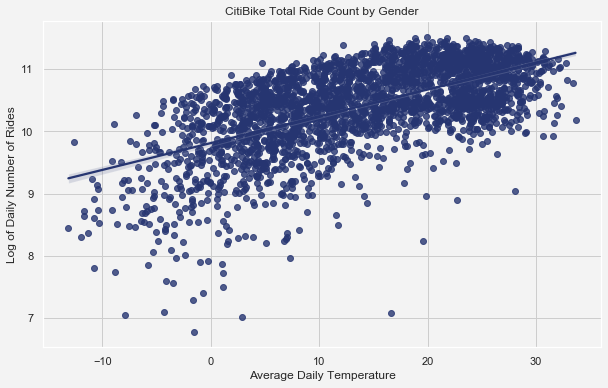

In [45]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571", "#263571", "#ea2029"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,6))
fig = sns.regplot(x = 'TMP_mean', y = Y, data = combined)
fig.set_title('CitiBike Total Ride Count by Gender', fontsize=12)
fig.set_xlabel('Average Daily Temperature', fontsize=12)
fig.set_ylabel('Log of Daily Number of Rides', fontsize=12)

Text(0, 0.5, 'Log of Daily Number of Rides')

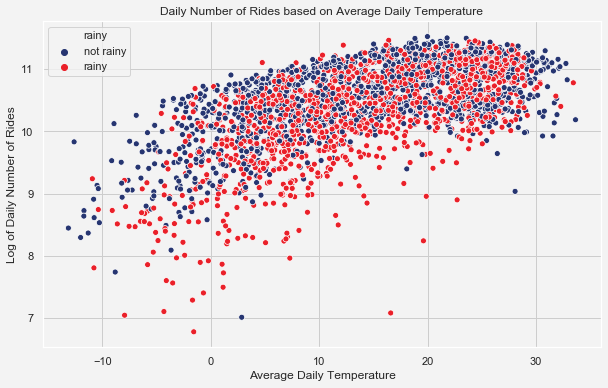

In [46]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571", "#ea2029", "#ea2029"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,6))
fig = sns.scatterplot(x = 'TMP_mean', y = Y, hue = 'rainy', data = combined)
fig.set_title('Daily Number of Rides based on Average Daily Temperature', fontsize=12)
fig.set_xlabel('Average Daily Temperature', fontsize=12)
fig.set_ylabel('Log of Daily Number of Rides', fontsize=12)

Text(0, 0.5, 'Daily Number of Rides')

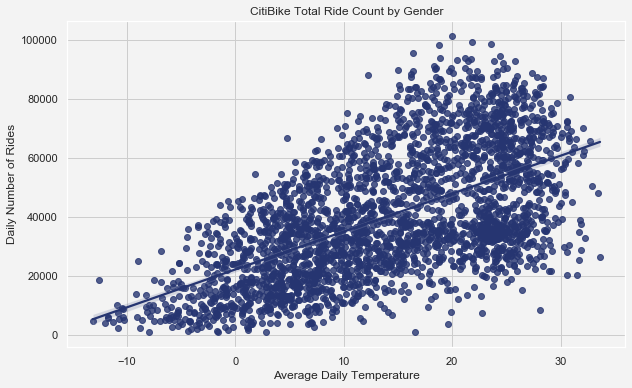

In [35]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571", "#263571", "#ea2029"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,6))
fig = sns.regplot(x = 'TMP_mean', y = 'counts', hue =  data = combined)
fig.set_title('CitiBike Total Ride Count by Gender', fontsize=12)
fig.set_xlabel('Average Daily Temperature', fontsize=12)
fig.set_ylabel('Daily Number of Rides', fontsize=12)

## Temperature / Wind Speed

Text(0, 0.5, 'Daily Number of Rides')

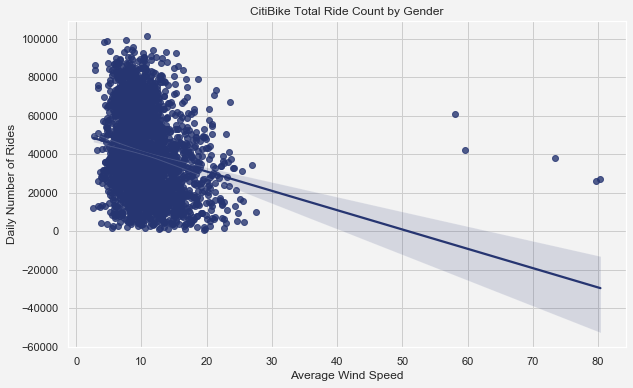

In [124]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571", "#263571", "#ea2029"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,6))
fig = sns.regplot(x = 'wind_speed_mean', y = 'counts', data = combined)
fig.set_title('CitiBike Total Ride Count by Gender', fontsize=12)
fig.set_xlabel('Average Wind Speed', fontsize=12)
fig.set_ylabel('Daily Number of Rides', fontsize=12)

### Remove Outliers


In [48]:
z_scores = stats.zscore(combined['wind_speed_mean'])

In [49]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [50]:
nonOutlierList = Remove_Outlier_Indices(combined['wind_speed_mean'])

In [51]:
dfSubset = combined[nonOutlierList]

In [52]:
dfSubset

,date,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum,counts,windy,rainy
0,2013-06-01,24.4,31.7,28.065625,8.100,13.950,10.610156,0.0,8398,calm,not rainy
1,2013-06-02,21.1,30.6,26.425000,8.100,18.450,11.601562,0.0,15430,calm,not rainy
2,2013-06-03,21.0,28.9,22.721053,0.000,15.075,8.301316,86.8,7325,calm,rainy
3,2013-06-04,15.0,23.9,19.781250,0.000,17.325,10.919531,39.6,15228,calm,rainy
4,2013-06-05,15.0,22.8,19.487500,0.000,13.950,8.191406,0.0,15173,calm,not rainy
...,...,...,...,...,...,...,...,...,...,...,...
2727,2020-11-26,11.7,19.0,15.260526,3.375,15.075,8.591447,56.4,30687,calm,rainy
2728,2020-11-27,11.7,17.2,14.900000,0.000,11.475,4.870161,5.3,53108,calm,rainy
2729,2020-11-28,10.0,14.4,12.025000,0.000,16.200,8.613281,0.0,53202,calm,not rainy
2730,2020-11-29,5.6,13.3,9.484375,0.000,13.950,6.848437,0.0,52557,calm,not rainy


In [53]:
Y = np.log(dfSubset['counts'])

Text(0, 0.5, 'Log of Daily Number of Rides')

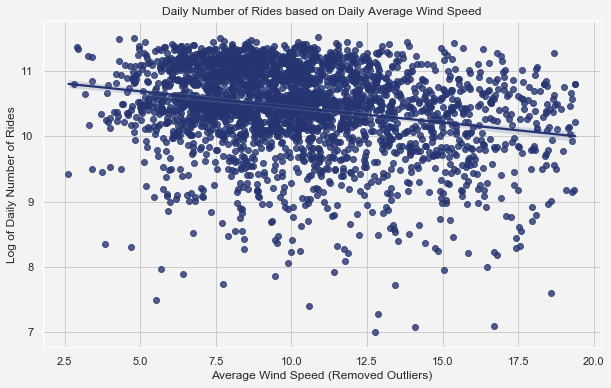

In [55]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571", "#263571", "#ea2029"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,6))
fig = sns.regplot(x = 'wind_speed_mean', y = Y, data = dfSubset)
fig.set_title('Daily Number of Rides based on Daily Average Wind Speed', fontsize=12)
fig.set_xlabel('Average Wind Speed (Removed Outliers)', fontsize=12)
fig.set_ylabel('Log of Daily Number of Rides', fontsize=12)

## Trend and Decomposition

Text(0, 0.5, 'Number of Counts (Dark Blue)')

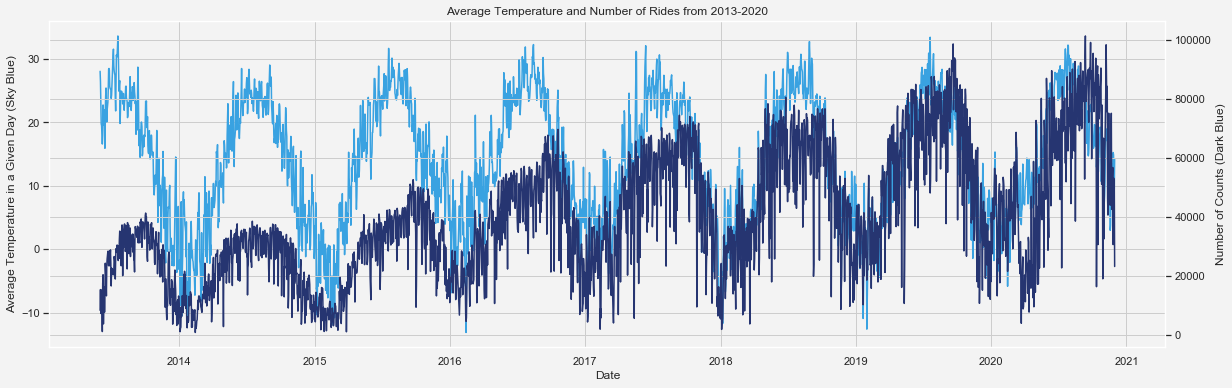

In [57]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()
sns.lineplot(x = 'date', y = 'TMP_mean', color = '#39a2e1', data = combined, ax = ax1)
sns.lineplot(x = 'date', y = 'counts', color = '#263571', data = combined, ax = ax2)
ax1.set_title('Average Temperature and Number of Rides from 2013-2020', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Average Temperature in a Given Day (Sky Blue)', fontsize=12)
ax2.set_ylabel('Number of Counts (Dark Blue)')

In [134]:
combined = daily_rides.merge(daily_temp, on = 'date', how = 'inner')

In [139]:
combined_roll = combined[['date', 'counts']]

In [141]:
combined_roll.set_index('date')

,counts
date,
2013-06-01,8398
2013-06-02,15430
2013-06-03,7325
2013-06-04,15228
2013-06-05,15173
...,...
2020-11-26,30687
2020-11-27,53108
2020-11-28,53202


In [146]:
combined_roll2 = combined_roll.rolling(window = 52).mean()

In [147]:
combined_roll2.isnull().sum()

counts    51
dtype: int64

In [119]:
combined['month'] = combined['date'].dt.strftime('%Y-%m')

In [124]:
combined_counts

,month,counts
0,2013-06,8398
1,2013-06,15430
2,2013-06,7325
3,2013-06,15228
4,2013-06,15173
...,...,...
2727,2020-11,30687
2728,2020-11,53108
2729,2020-11,53202
2730,2020-11,52557


In [115]:
combined_monthly = combined.groupby(['month'])[['counts']].agg(['mean'])
combined_monthly.columns = ["_".join(x) for x in combined_monthly.columns.ravel()]

In [111]:
combined_monthly = combined_monthly.rolling(window = 3)

In [112]:
combined_monthly

Rolling [window=3,center=False,axis=0]

In [172]:
# Import statsmodels.api as sm
import statsmodels.api as sm

# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(combined_monthly, model = 'additive', freq = 7)

# Extract the trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal

/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


In [173]:
trend

month
2013-06             NaN
2013-07             NaN
2013-08             NaN
2013-09    26140.498618
2013-10    24859.863748
               ...     
2020-07    61722.502304
2020-08    66741.273733
2020-09             NaN
2020-10             NaN
2020-11             NaN
Name: trend, Length: 90, dtype: float64

In [174]:
seasonal

month
2013-06    -598.375979
2013-07    -868.827541
2013-08    1026.762702
2013-09     492.815691
2013-10    1174.880380
              ...     
2020-07    -868.827541
2020-08    1026.762702
2020-09     492.815691
2020-10    1174.880380
2020-11    -911.640066
Name: seasonal, Length: 90, dtype: float64

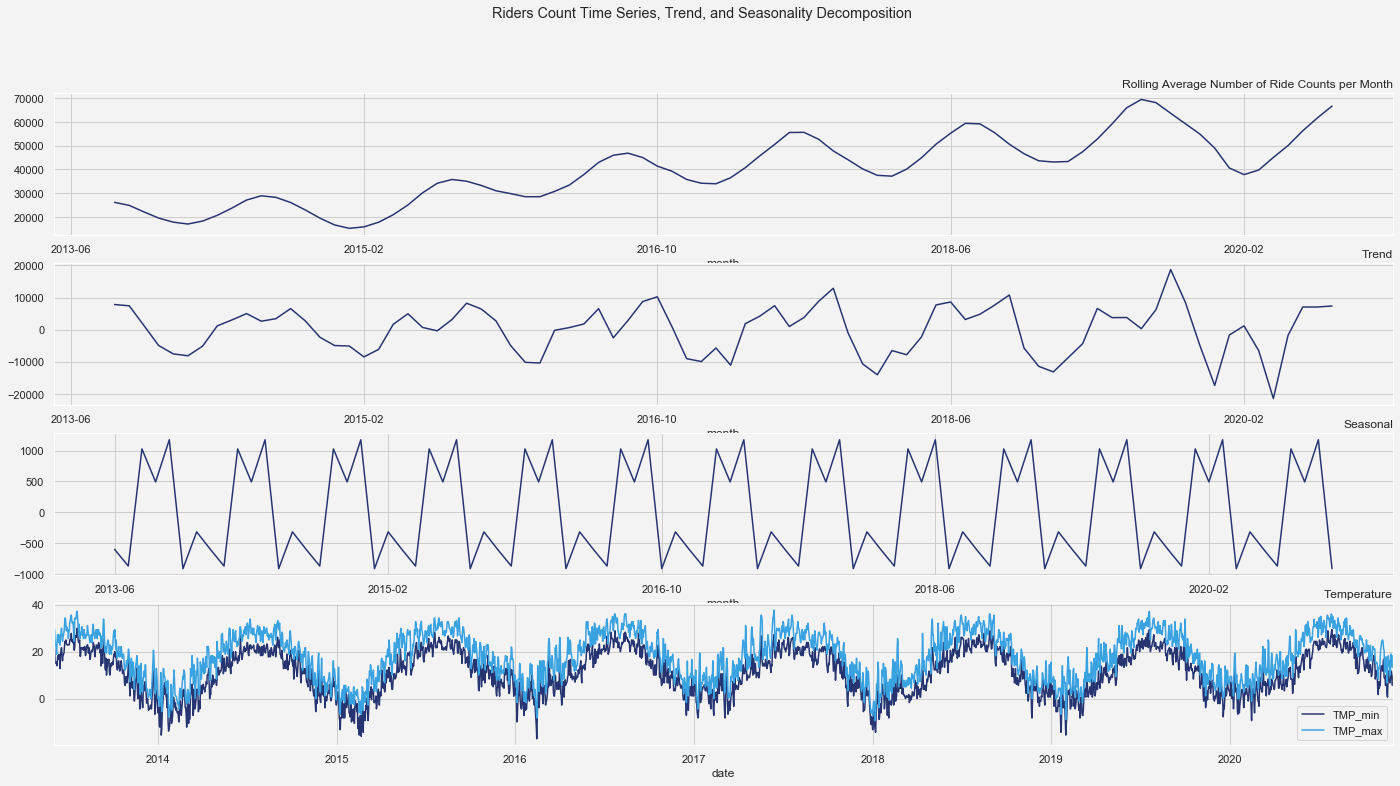

In [233]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(24,12))
colors = ["#263571", "#39a2e1", "#263571"]
sns.set_palette(sns.color_palette(colors))
fig.suptitle('Riders Count Time Series, Trend, and Seasonality Decomposition')
decomposition.trend.plot(ax=ax1, color = colors)
decomposition.resid.plot(ax=ax2, color = colors)
decomposition.seasonal.plot(ax=ax3, color = colors)
daily_temp2.plot(ax=ax4, color = colors)
ax1.set_title('Rolling Average Number of Ride Counts per Month',loc = 'right')
ax2.set_title('Trend', loc = 'right')
ax3.set_title('Seasonal', loc = 'right')
ax4.set_title('Temperature', loc = 'right')
plt.show()

In [213]:
daily_temp2=daily_temp.set_index('date')

In [214]:
daily_temp2 = daily_temp2.loc['2013-06-01':'2020-11-30']

In [217]:
daily_temp2=daily_temp2[['TMP_min','TMP_max']]

In [66]:
combined2 = rides.merge(daily_temp, on = 'date', how = 'inner')

In [85]:
combined2

,tripduration,starttime,usertype,birth year,gender,season,dayofweek,date,month,year,hour,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum
0,362,2017-09-01 00:00:17.000,Subscriber,1993,1,fall,Friday,2017-09-01,2017-09,2017,0,13.3,22.8,18.515625,4.725,17.325,12.445312,0.0
1,188,2017-09-01 00:00:21.000,Subscriber,1988,1,fall,Friday,2017-09-01,2017-09,2017,0,13.3,22.8,18.515625,4.725,17.325,12.445312,0.0
2,305,2017-09-01 00:00:25.000,Subscriber,1969,1,fall,Friday,2017-09-01,2017-09,2017,0,13.3,22.8,18.515625,4.725,17.325,12.445312,0.0
3,223,2017-09-01 00:00:52.000,Subscriber,1993,1,fall,Friday,2017-09-01,2017-09,2017,0,13.3,22.8,18.515625,4.725,17.325,12.445312,0.0
4,758,2017-09-01 00:01:01.000,Subscriber,1987,1,fall,Friday,2017-09-01,2017-09,2017,0,13.3,22.8,18.515625,4.725,17.325,12.445312,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110341608,1587,2020-01-31 23:59:26.882,Subscriber,1990,1,winter,Friday,2020-01-31,2020-01,2020,23,0.0,6.0,2.252632,4.725,9.225,6.382895,0.0
110341609,222,2020-01-31 23:59:32.641,Subscriber,1983,1,winter,Friday,2020-01-31,2020-01,2020,23,0.0,6.0,2.252632,4.725,9.225,6.382895,0.0
110341610,163,2020-01-31 23:59:39.178,Subscriber,1958,2,winter,Friday,2020-01-31,2020-01,2020,23,0.0,6.0,2.252632,4.725,9.225,6.382895,0.0
110341611,327,2020-01-31 23:59:49.231,Customer,1994,1,winter,Friday,2020-01-31,2020-01,2020,23,0.0,6.0,2.252632,4.725,9.225,6.382895,0.0


In [216]:
combined_2019 = combined.loc['2019-01-01':'2019-12-31']

In [218]:
combined_2019.reset_index()

,date,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum,counts,windy,rainy,precipitation_sum_nonzero,log_precipitation_sum
0,2019-01-01,6.7,15.6,10.246939,0.000,27.900,14.730612,105.9,21962,calm,rainy,105.9000,4.662495
1,2019-01-02,1.7,6.7,3.640625,3.375,17.325,9.682031,0.0,37797,calm,not rainy,0.0001,-9.210340
2,2019-01-03,2.8,7.2,5.372973,0.000,20.925,10.739189,0.0,41676,calm,not rainy,0.0001,-9.210340
3,2019-01-04,2.8,8.3,5.021875,5.850,17.325,10.307812,0.0,43922,calm,not rainy,0.0001,-9.210340
4,2019-01-05,5.6,8.3,6.761111,3.375,20.925,13.058333,30.2,17432,calm,rainy,30.2000,3.407842
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,6.1,12.2,9.356757,4.725,13.950,8.489189,0.0,31808,calm,not rainy,0.0001,-9.210340
361,2019-12-28,7.0,11.7,9.039394,0.000,13.950,8.427273,0.0,28520,calm,not rainy,0.0001,-9.210340
362,2019-12-29,4.4,8.3,5.615625,0.000,11.475,7.502344,2.1,17968,calm,rainy,2.1000,0.741937
363,2019-12-30,3.9,6.1,4.867213,8.100,30.150,16.926639,53.6,12138,windy,rainy,53.6000,3.981549


In [245]:
daily_temp2 = weather_df.groupby(["date","hour"]).agg({
  "TMP" : ['min', 'max', 'mean'], 
  "wind_speed" : ["min", 'max', 'mean'], 
  "precipitation" : ["sum"]
  }).reset_index()
daily_temp2.columns = ["_".join(x) for x in daily_temp2.columns.ravel()]


In [246]:
daily_temp2 = daily_temp2.rename(columns = {'date_': 'date', 'hour_':'hour'})

In [249]:
daily_temp2['date'] = pd.to_datetime(daily_temp2['date'])

In [228]:
daily_rides2 = rides.groupby(['date','hour'])[['hour']].count().rename(columns={'hour': 'counts'}).reset_index()

In [238]:
daily_rides2 = daily_rides2.set_index(['date'])

In [239]:
daily_rides2019 = daily_rides2.loc['2019-01-01':'2019-12-31']

In [251]:
daily_temp2 = daily_temp2.set_index(['date'])

In [253]:
daily_temp2019 = daily_temp2.loc['2019-01-01':'2019-12-31']

In [254]:
combined_hourly = daily_rides2019.merge(daily_temp2019, left_on = ['date', 'hour'], right_on = ['date', 'hour'], how = 'inner')

In [256]:
combined_hourly.reset_index()

,date,hour,counts,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum
0,2019-01-01,0,133,6.7,7.0,6.80,9.225,15.075,13.12500,11.1
1,2019-01-01,1,272,7.0,7.2,7.16,10.350,13.950,12.01500,11.3
2,2019-01-01,2,283,7.8,7.8,7.80,11.475,13.950,12.71250,16.0
3,2019-01-01,3,187,7.8,8.0,7.85,6.975,13.950,11.30625,27.9
4,2019-01-01,4,120,8.3,8.3,8.30,6.975,6.975,6.97500,5.1
...,...,...,...,...,...,...,...,...,...,...
8753,2019-12-31,19,1171,7.2,7.2,7.20,4.725,4.725,4.72500,0.0
8754,2019-12-31,20,719,7.2,7.2,7.20,10.350,10.350,10.35000,0.0
8755,2019-12-31,21,555,7.2,7.2,7.20,10.350,13.950,12.15000,0.0
8756,2019-12-31,22,560,7.2,7.2,7.20,10.350,10.350,10.35000,0.0


In [ ]:
combined_hourly = combined_hourly[['date', 'TMP_min', 'TMP_max', 'TMP_mean', 'wind_speed_min', \
                                   'wind_speed_max', 'wind_speed_mean', 'precipitation_sum', 'counts']]

In [ ]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()
sns.lineplot(x = '', y = 'TMP_mean', color = '#39a2e1', data = combined, ax = ax1)
sns.lineplot(x = 'date', y = 'counts', color = '#263571', data = combined, ax = ax2)
ax1.set_title('Average Temperature and Number of Rides from 2013-2020', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Average Temperature in a Given Day (Sky Blue)', fontsize=12)
ax2.set_ylabel('Number of Counts (Dark Blue)')

In [257]:
rides['datehour'] = rides['starttime'].dt.strftime('%Y-%m-%d-%H')

In [259]:
weather_df['datehour'] = weather_df['DATE'].dt.strftime('%Y-%m-%d-%H')

In [282]:
daily_temp3 = weather_df.groupby(["datehour"]).agg({
  "TMP" : ['min', 'max', 'mean'], 
  "wind_speed" : ["min", 'max', 'mean'], 
  "precipitation" : ["sum"]
  }).reset_index()
daily_temp3.columns = ["_".join(x) for x in daily_temp3.columns.ravel()]


In [283]:
daily_temp3

,datehour_,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum
0,2013-01-01-00,3.3,3.9,3.6,13.950,17.325,15.6375,0.0
1,2013-01-01-01,3.9,3.9,3.9,13.950,13.950,13.9500,0.0
2,2013-01-01-02,4.4,4.4,4.4,15.075,15.075,15.0750,0.0
3,2013-01-01-03,4.4,4.4,4.4,15.075,16.200,15.6375,0.0
4,2013-01-01-04,5.0,5.0,5.0,18.450,18.450,18.4500,0.0
...,...,...,...,...,...,...,...,...
69602,2020-12-10-03,3.9,3.9,3.9,13.950,13.950,13.9500,0.0
69603,2020-12-10-04,4.4,4.4,4.4,10.350,10.350,10.3500,0.0
69604,2020-12-10-05,3.9,3.9,3.9,8.100,8.100,8.1000,0.0
69605,2020-12-10-06,4.4,4.4,4.4,10.350,10.350,10.3500,0.0


In [286]:
daily_rides3 = rides.groupby(['datehour'])[['datehour']].count().rename(columns={'datehour': 'counts'}).reset_index()

In [284]:
daily_temp3 = daily_temp3.rename(columns = {'datehour_': 'datehour'})

In [285]:
daily_temp3

,datehour,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum
0,2013-01-01-00,3.3,3.9,3.6,13.950,17.325,15.6375,0.0
1,2013-01-01-01,3.9,3.9,3.9,13.950,13.950,13.9500,0.0
2,2013-01-01-02,4.4,4.4,4.4,15.075,15.075,15.0750,0.0
3,2013-01-01-03,4.4,4.4,4.4,15.075,16.200,15.6375,0.0
4,2013-01-01-04,5.0,5.0,5.0,18.450,18.450,18.4500,0.0
...,...,...,...,...,...,...,...,...
69602,2020-12-10-03,3.9,3.9,3.9,13.950,13.950,13.9500,0.0
69603,2020-12-10-04,4.4,4.4,4.4,10.350,10.350,10.3500,0.0
69604,2020-12-10-05,3.9,3.9,3.9,8.100,8.100,8.1000,0.0
69605,2020-12-10-06,4.4,4.4,4.4,10.350,10.350,10.3500,0.0


In [287]:
combined_hourly2 = daily_rides3.merge(daily_temp3, on = 'datehour', how = 'inner')

In [288]:
combined_hourly2

,datehour,counts,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum
0,2013-06-01-00,149,28.9,29.4,29.15,8.100,9.225,8.6625,0.0
1,2013-06-01-01,101,28.3,28.3,28.30,8.100,8.100,8.1000,0.0
2,2013-06-01-02,64,28.9,28.9,28.90,8.100,8.100,8.1000,0.0
3,2013-06-01-03,39,28.3,28.9,28.60,8.100,9.225,8.6625,0.0
4,2013-06-01-04,15,27.2,27.2,27.20,9.225,9.225,9.2250,0.0
...,...,...,...,...,...,...,...,...,...
65458,2020-11-30-19,1805,17.8,17.8,17.80,23.175,25.425,24.3000,0.5
65459,2020-11-30-20,1191,17.2,17.2,17.20,20.925,20.925,20.9250,0.0
65460,2020-11-30-21,952,17.2,18.3,17.75,20.925,24.300,22.6125,0.0
65461,2020-11-30-22,841,17.8,17.8,17.80,19.800,20.925,20.3625,0.5


In [307]:
combined_hourly3 = combined_hourly2.copy()

In [308]:
combined_hourly3['datehour'] = pd.to_datetime(combined_hourly3['datehour'])

In [1]:
combined_hourly3[['datehour']]

NameError: name 'combined_hourly3' is not defined

In [310]:
combined_hourly3 = combined_hourly3.set_index(['datehour'])

In [311]:
combined_hourly3 = combined_hourly3.loc['2019-09-01':'2019-09-30']

In [312]:
combined_hourly3 = combined_hourly3.reset_index()

In [313]:
combined_hourly3

,datehour,counts,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum
0,2019-09-01 00:00:00,1083,23.3,25.0,24.15,8.100,8.100,8.1000,0.0
1,2019-09-01 01:00:00,702,23.3,23.3,23.30,6.975,6.975,6.9750,0.0
2,2019-09-01 02:00:00,455,22.8,22.8,22.80,11.475,11.475,11.4750,0.0
3,2019-09-01 03:00:00,295,22.2,22.8,22.50,10.350,11.475,10.9125,0.0
4,2019-09-01 04:00:00,209,21.7,21.7,21.70,6.975,6.975,6.9750,0.0
...,...,...,...,...,...,...,...,...,...
715,2019-09-30 19:00:00,5220,20.0,20.0,20.00,10.350,10.350,10.3500,0.0
716,2019-09-30 20:00:00,3551,20.6,20.6,20.60,12.825,12.825,12.8250,0.0
717,2019-09-30 21:00:00,2470,19.4,20.6,20.00,11.475,12.825,12.1500,0.0
718,2019-09-30 22:00:00,1683,19.4,19.4,19.40,10.350,10.350,10.3500,0.0


Text(0, 0.5, 'Number of Counts (Dark Blue)')

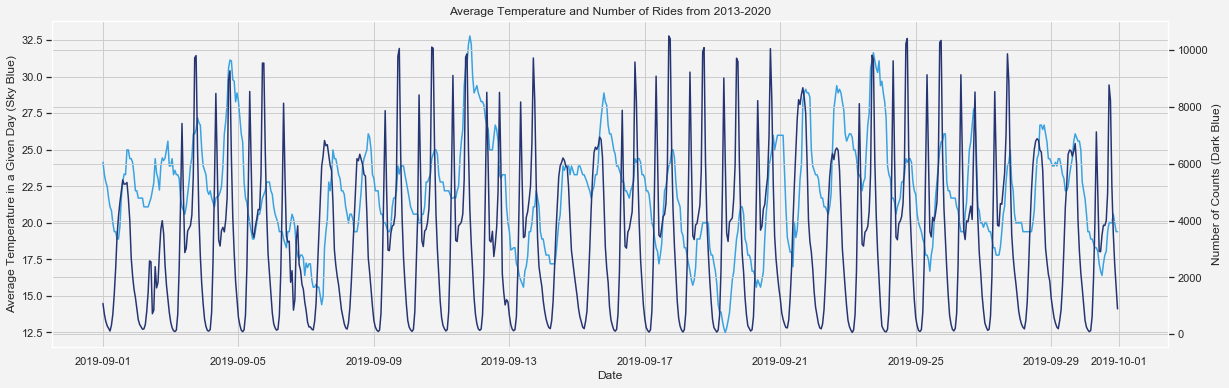

In [314]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()
sns.lineplot(x = 'datehour', y = 'TMP_mean', color = '#39a2e1', data = combined_hourly3, ax = ax1)
sns.lineplot(x = 'datehour', y = 'counts', color = '#263571', data = combined_hourly3, ax = ax2)
ax1.set_title('Average Temperature and Number of Rides from 2013-2020', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Average Temperature in a Given Day (Sky Blue)', fontsize=12)
ax2.set_ylabel('Number of Counts (Dark Blue)')

Text(0, 0.5, 'Number of Counts (Dark Blue)')

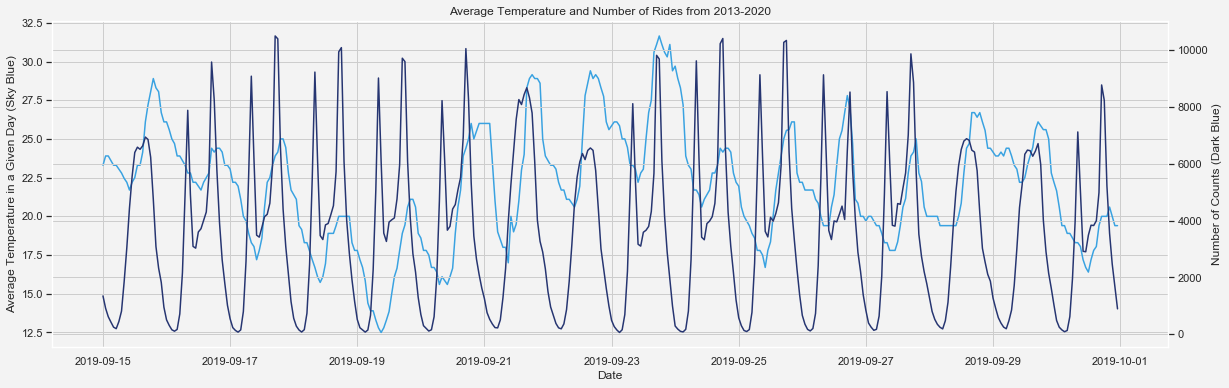

In [315]:
combined_hourly4 = combined_hourly2.copy()
combined_hourly4['datehour'] = pd.to_datetime(combined_hourly4['datehour'])
combined_hourly4 = combined_hourly4.set_index(['datehour'])
combined_hourly4 = combined_hourly4.loc['2019-09-15':'2019-09-30']
combined_hourly4 = combined_hourly4.reset_index()
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()
sns.lineplot(x = 'datehour', y = 'TMP_mean', color = '#39a2e1', data = combined_hourly4, ax = ax1)
sns.lineplot(x = 'datehour', y = 'counts', color = '#263571', data = combined_hourly4, ax = ax2)
ax1.set_title('Average Temperature and Number of Rides from 2013-2020', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Average Temperature in a Given Day (Sky Blue)', fontsize=12)
ax2.set_ylabel('Number of Counts (Dark Blue)')

In [7]:
dock = pd.read_csv('../data/stations_cleaned.csv.gz')

/Users/danielchoy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
dock['date'] = pd.to_datetime(dock['date'])
dock['date_time'] = dock['date'].dt.strftime('%Y-%m-%d')

In [9]:
daily_bikes = dock.groupby(['date_time']).agg({'avail_bikes':'mean', 'avail_docks':'mean','tot_docks':'mean'}).reset_index()

In [10]:
daily_bikes.rename(columns={'avail_bikes':'avg_available_bikes', 'avail_docks':'avg_bikes_Used','tot_docks':'avg_total_docks'}, inplace=True)    

In [11]:
daily_bikes['Usage Rate'] = daily_bikes['avg_bikes_Used']/(daily_bikes['avg_total_docks'])

In [18]:
daily_temp = weather_df.groupby(["date"]).agg({
  "TMP" : ['min', 'max', 'mean'], 
  "wind_speed" : ["min", 'max', 'mean'], 
  "precipitation" : ["sum"]
  }).reset_index()
daily_temp.columns = ["_".join(x) for x in daily_temp.columns.ravel()]

In [13]:
daily_bikes

,date_time,avg_available_bikes,avg_bikes_Used,avg_total_docks,Usage Rate
0,2015-03-01,8.625210,25.450128,34.460913,0.738522
1,2015-03-02,8.535919,25.521011,34.534684,0.738997
2,2015-03-03,9.150600,25.098664,34.732100,0.722636
3,2015-03-04,9.020232,25.387633,34.760086,0.730367
4,2015-03-05,7.329244,27.070639,34.775091,0.778449
...,...,...,...,...,...
1328,2019-04-26,12.387680,19.166148,32.822062,0.583941
1329,2019-04-27,12.534284,19.081129,32.879551,0.580334
1330,2019-04-28,12.660132,18.962230,32.858190,0.577093
1331,2019-04-29,11.744630,19.904638,32.790805,0.607019


In [19]:
daily_temp = daily_temp.rename(columns = {'date_': 'date_time'})

In [25]:
daily_temp['date_time'] = pd.to_datetime(daily_temp['date_time'])

In [26]:
daily_bikes['date_time'] = pd.to_datetime(daily_bikes['date_time'])

In [27]:
daily_temp = daily_temp.set_index(['date_time'])

In [28]:
daily_temp = daily_temp.loc['2015-03-01':'2019-04-30']

In [29]:
daily_temp = daily_temp.reset_index()

In [30]:
daily_bikes = daily_bikes.set_index(['date_time'])
daily_bikes = daily_bikes.loc['2015-03-01':'2019-04-30']
daily_bikes = daily_bikes.reset_index()

In [31]:
daily_temp

,date_time,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum
0,2015-03-01,-4.4,-1.1,-3.153333,0.000,15.075,5.700000,27.4
1,2015-03-02,-2.8,3.3,-0.365217,0.000,25.425,8.378804,29.2
2,2015-03-03,-4.4,1.7,-1.854762,0.000,22.050,11.351786,12.8
3,2015-03-04,0.0,8.3,3.213333,0.000,15.075,9.800000,52.9
4,2015-03-05,-6.0,6.7,-0.669231,4.725,18.450,10.588846,59.7
...,...,...,...,...,...,...,...,...
1517,2019-04-26,10.6,15.0,11.569492,0.000,20.925,12.085169,63.7
1518,2019-04-27,10.0,15.0,12.784211,6.975,26.550,18.065132,28.9
1519,2019-04-28,8.9,11.7,9.886842,0.000,17.325,10.355921,0.0
1520,2019-04-29,6.7,13.9,9.888235,4.725,15.075,10.561765,0.0


In [32]:
combined_dock = daily_bikes.merge(daily_temp, on = 'date_time', how = 'inner')

In [33]:
combined_dock

,date_time,avg_available_bikes,avg_bikes_Used,avg_total_docks,Usage Rate,TMP_min,TMP_max,TMP_mean,wind_speed_min,wind_speed_max,wind_speed_mean,precipitation_sum
0,2015-03-01,8.625210,25.450128,34.460913,0.738522,-4.4,-1.1,-3.153333,0.000,15.075,5.700000,27.4
1,2015-03-02,8.535919,25.521011,34.534684,0.738997,-2.8,3.3,-0.365217,0.000,25.425,8.378804,29.2
2,2015-03-03,9.150600,25.098664,34.732100,0.722636,-4.4,1.7,-1.854762,0.000,22.050,11.351786,12.8
3,2015-03-04,9.020232,25.387633,34.760086,0.730367,0.0,8.3,3.213333,0.000,15.075,9.800000,52.9
4,2015-03-05,7.329244,27.070639,34.775091,0.778449,-6.0,6.7,-0.669231,4.725,18.450,10.588846,59.7
...,...,...,...,...,...,...,...,...,...,...,...,...
1328,2019-04-26,12.387680,19.166148,32.822062,0.583941,10.6,15.0,11.569492,0.000,20.925,12.085169,63.7
1329,2019-04-27,12.534284,19.081129,32.879551,0.580334,10.0,15.0,12.784211,6.975,26.550,18.065132,28.9
1330,2019-04-28,12.660132,18.962230,32.858190,0.577093,8.9,11.7,9.886842,0.000,17.325,10.355921,0.0
1331,2019-04-29,11.744630,19.904638,32.790805,0.607019,6.7,13.9,9.888235,4.725,15.075,10.561765,0.0


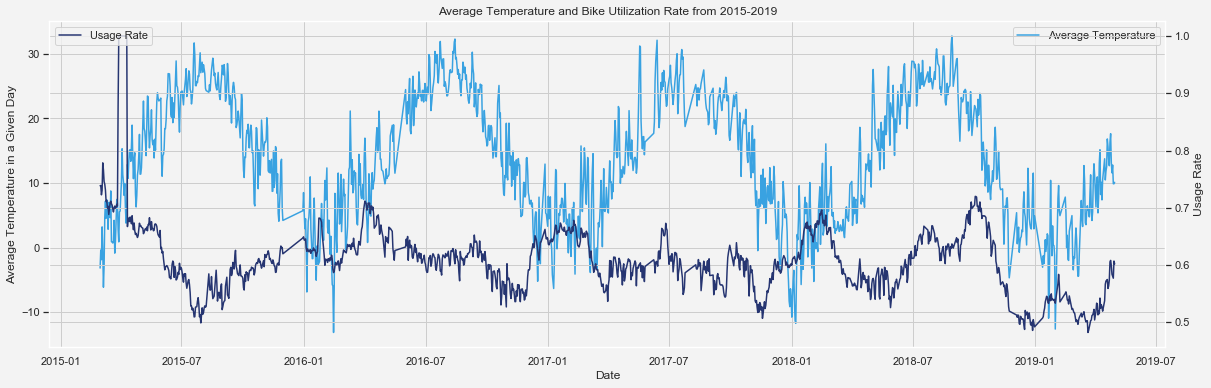

In [46]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()
sns.lineplot(x = 'date_time', y = 'TMP_mean', color = '#39a2e1', data = combined_dock, ax = ax1)
sns.lineplot(x = 'date_time', y = 'Usage Rate', color = '#263571', data = combined_dock, ax = ax2)
ax1.set_title('Average Temperature and Bike Utilization Rate from 2015-2019', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Average Temperature in a Given Day', fontsize=12)
ax2.set_ylabel('Usage Rate')
ax1.legend(labels=["Average Temperature"])
ax2.legend(labels=["Usage Rate"], loc = 'upper left')

In [37]:
combined_dock2 = combined_dock.copy()

In [38]:
combined_dock2 = combined_dock2.set_index(['date_time'])
combined_dock2 = combined_dock2.loc['2018-01-01':'2018-12-31']
combined_dock2 = combined_dock2.reset_index()

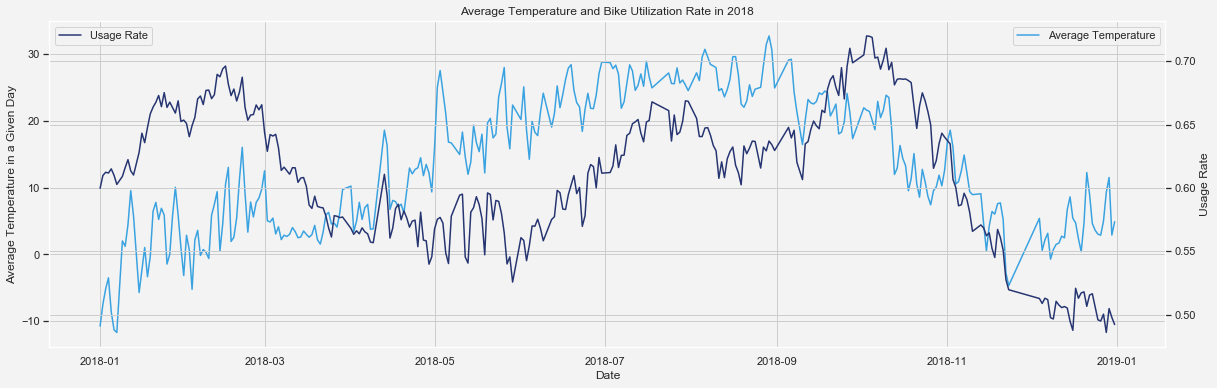

In [47]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()
sns.lineplot(x = 'date_time', y = 'TMP_mean', color = '#39a2e1', data = combined_dock2, ax = ax1)
sns.lineplot(x = 'date_time', y = 'Usage Rate', color = '#263571', data = combined_dock2, ax = ax2)
ax1.set_title('Average Temperature and Bike Utilization Rate in 2018', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Average Temperature in a Given Day', fontsize=12)
ax2.set_ylabel('Usage Rate')
ax1.legend(labels=["Average Temperature"])
ax2.legend(labels=["Usage Rate"], loc = 'upper left')

In [48]:
combined_dock['rainy'] = combined_dock['precipitation_sum'].apply(lambda x: 'rainy' if x > 0 else 'not rainy')

In [49]:
combined_dock['windy'] = combined_dock['wind_speed_mean'].apply(lambda x: 'calm' if x < 15 else 'windy')

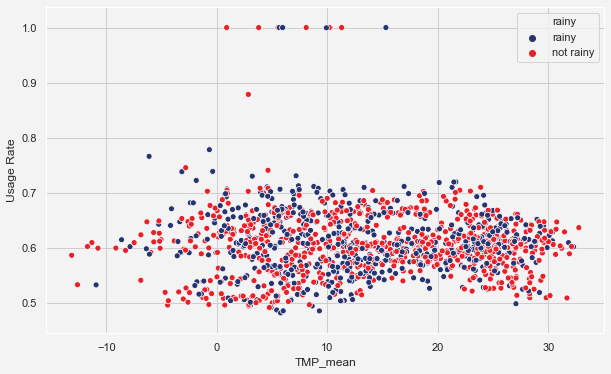

In [50]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571", "#ea2029", "#ea2029"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,6))
fig = sns.scatterplot(x = 'TMP_mean', y = 'Usage Rate', hue = 'rainy', data = combined_dock)
# fig.set_title('Daily Number of Rides based on Average Daily Temperature', fontsize=12)
# fig.set_xlabel('Average Daily Temperature', fontsize=12)
# fig.set_ylabel('Daily Number of Rides', fontsize=12)

In [51]:
combined_dock['month'] = combined_dock.date_time.dt.month.apply(lambda x: 'Jan' if x == 1 else 'Feb' if x == 2 else \
    'Mar' if x == 3 else 'Apr' if x == 4 else 'May' if x == 5 else 'Jun' if x == 6 else 'Jul' if x == 7 else \
    'Aug' if x == 8 else 'Sep' if x == 9 else 'Oct' if x == 10 else 'Nov' if x == 11 else 'Dec' )

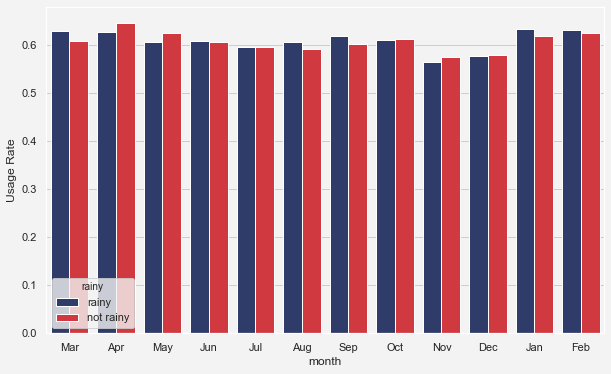

In [55]:
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
colors = ["#263571", "#ea2029", "#ea2029"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (10,6))
fig = sns.barplot(x = 'month', y = 'Usage Rate', hue = 'rainy', data = combined_dock, ci = False)